# Обзор и тестирование `Direct density ratio estimation`

In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


/home/rosneft_user_2500/anomaly-detection


In [2]:
root_folder = %pwd
import sys
sys.path = [root_folder] + sys.path

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cufflinks as cf
from src.features.build_features import rolling_window
from src.models.DDRE import *

cf.go_offline(connected=True)

from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [4]:
plotly_layout = dict(
    autosize=False,
    width=700,
    height=480,
)

## Установка параметров модели

In [5]:
DDRE_search_params = dict(
    width_candidates=[50, 55, 60, 65],
    sigma_candidates=np.array([0.1, 0.5, 1, 5, 10, 20, 50, 100], dtype=np.float32),
    chunk_size=50,
    R=3,
)

DDRE_params = dict(
    n_rf_te=32,
    verbose=False,
    # build args
    eps=0.001, min_delta=0.01, iterations=100,
    # update args
    learning_rate=1, reg_parameter=0.01,
    chunks=1
)

## Тестирование на синтетических данных

### Пример 1

$$y_t= 0.6y_{t−1}−0.5y{t−2}+\epsilon$$

$$y_1=0, \quad y_2=0, \quad t=\overline{1, 1000}$$

$$\epsilon \sim \mathcal{N}(\mu,\,1)$$

где $\mu=\mu + i \quad$ при $t=100 * i$

In [6]:
# Lets check algorithm on synthetic dataset
n = 1000
mean = 0
step = 100
y = np.zeros(n, dtype=float)
for i in range(2, n):
    if i % step == 0:
        mean = mean + i // step
    y[i] = y[i-1]*0.6 - y[i-2]*0.5 + mean + np.random.randn()

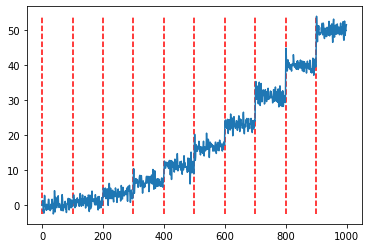

In [7]:
plt.plot(y)
plt.vlines(list(range(0, n, step)), np.min(y), np.max(y), linestyle='--', colors='r')

In [8]:
ratios, chng_pts, peaks = compute_ratios_hp(y.reshape(-1, 1), DDRE_search_params, DDRE_params)

Finding hyperparams...
Candidate 50


/home/rosneft_user_2500/anomaly-detection/src/models/DDRE.py:171: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, A))

/home/rosneft_user_2500/anomaly-detection/src/models/DDRE.py:171: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))



Optimal sigma is: 10.0


/home/rosneft_user_2500/anomaly-detection/src/models/DDRE.py:244: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))



Computing ratios in parrallel with 1 chunks
Candidate 55
Optimal sigma is: 10.0
Computing ratios in parrallel with 1 chunks
Candidate 60
Optimal sigma is: 10.0
Computing ratios in parrallel with 1 chunks
Candidate 65
Optimal sigma is: 10.0
Computing ratios in parrallel with 1 chunks

Optimal width is 65

Starting compute ratios...
Computing ratios in parrallel with 1 chunks


In [9]:
pd.DataFrame(dict(ratios=ratios)).iplot(layout=plotly_layout)

### Пример 2

$y_{t}=e_{t}+\left\{\begin{aligned} 0.97 y_{t-1}+y_{t-2}-0.5 y_{t-3}+0.97 y_{t-4} \\ \text { if } t<1000 \\ 0.97 y_{t-1}+y_{t-2}-0.7 y_{t-3}+0.97 y_{t-4} \\ \text { if } t \geq 1000 \end{aligned}\right.$

где $e_{t} \sim \mathcal{N}(\mu,\,0.2), \quad y_{1}=0 , y_{2}=8, y_{3}=6, y_{4}=4 $

Точка изменения при $t=1000$

In [10]:
y = [0, 8, 6, 4]

for i in range(4, 1000):
    y.append(0.97 * y[i-1] + 0.4 * y[i - 2] - 0.5 * y[i-3] + 0.2 * np.random.randn())
for i in range(1000, 1500):
    y.append(0.97 * y[i-1] + 0.4 * y[i - 2] - 0.8 * y[i-3] + 0.2 * np.random.randn())

true_change_points = [1000]
y = np.array(y).reshape(-1,1)

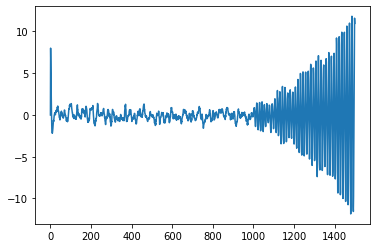

In [11]:
plt.plot(y)

In [12]:
DDRE_search_params['width_candidates'] = [400, 500, 600]
ratios, chng_pts, peaks = compute_ratios_hp(y.reshape(-1, 1), DDRE_search_params, DDRE_params)

Finding hyperparams...
Candidate 400
Optimal sigma is: 1.0
Computing ratios in parrallel with 1 chunks
Candidate 500
Optimal sigma is: 5.0
Computing ratios in parrallel with 1 chunks
Candidate 600
Optimal sigma is: 5.0
Computing ratios in parrallel with 1 chunks

Optimal width is 600

Starting compute ratios...
Computing ratios in parrallel with 1 chunks


In [13]:
pd.DataFrame(dict(ratios=ratios)).iplot(layout=plotly_layout)

### Смешание

$$x_t = \frac{t}{100}, \quad t=\overline{0, 200}, \quad т.е. x \in [0,2]$$

$$\vec{y_1} = sin(2\pi \vec{x})$$

$$\vec{y_2} = sin(4\pi \vec{x})$$

$$\vec{y_3} = sinh(2(\vec{x}-1))$$

$$\vec{y_4} = cosh(2(\vec{x}-1))$$

$$\vec{y_5} = e^{2(\vec{x}-1)}$$

In [14]:
x = np.linspace(0, 2, num=200)
y1 = np.sin(2 * np.pi * x)
y2 = np.sin(4 * np.pi * x)
y3 = np.sinh((x - 1) * 2)
y4 = np.cosh((x - 1) * 2)
y5 = np.exp((x - 1) * 2)

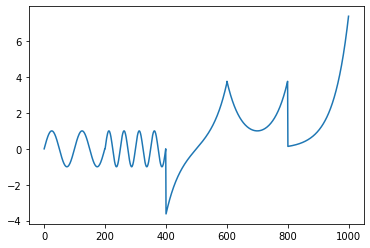

In [15]:
y = np.hstack((y1, y2, y3, y4, y5)).reshape(-1, 1)
plt.plot(y)

In [16]:
DDRE_search_params['width_candidates'] = [20, 40, 50, 60]
ratios, chng_pts, peaks = compute_ratios_hp(y.reshape(-1, 1), DDRE_search_params, DDRE_params)

Finding hyperparams...
Candidate 20
Optimal sigma is: 50.0
Computing ratios in parrallel with 1 chunks
Candidate 40
Optimal sigma is: 5.0
Computing ratios in parrallel with 1 chunks
Candidate 50
Optimal sigma is: 0.5
Computing ratios in parrallel with 1 chunks
Candidate 60
Optimal sigma is: 0.5
Computing ratios in parrallel with 1 chunks

Optimal width is 50

Starting compute ratios...
Computing ratios in parrallel with 1 chunks


In [17]:
pd.DataFrame(dict(ratios=ratios)).iplot(layout=plotly_layout)

## Реальные данные

In [18]:
data = pd.read_csv('data/processed/tep_data.csv', index_col='Index')
print(f'Len of dataset: {data.shape[0]}')

Len of dataset: 12801


In [19]:
DDRE_search_params = dict(
    width_candidates=[100, 200, 300, 500],
    sigma_candidates=np.array([0.1, 0.5, 1, 5, 10, 25, 50, 100], dtype=np.float32),
    chunk_size=300,
    R=3,
)

DDRE_params = dict(
    n_rf_te=32,
    verbose=True,
    # build args
    eps=0.001, min_delta=0.01, iterations=100,
    # update args
    learning_rate=1, reg_parameter=0.01,
    chunks=3
)

In [20]:
from src.data.generate import insert_anomalies

anomalies_kwargs = dict(
    amount=30,
    axis=0,
    anomaly_length=200
)

changed_df, anom_start_idxs = insert_anomalies(data, **anomalies_kwargs)

Задание параметров

Подбор ширины окна и "дисперсии"

In [ ]:
ratios, chng_pts, peaks = compute_ratios_hp(changed_df, DDRE_search_params, DDRE_params)

Finding hyperparams...
Candidate 100
Optimal sigma is: 100.0


/home/rosneft_user_2500/anomaly-detection/src/models/DDRE.py:244: NumbaPerformanceWarning:

np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))



Computing ratios in parrallel with 3 chunks
1 50 %
2 50 %
0 50 %
1 55 %
2 55 %
0 55 %
1 60 %
2 60 %
0 60 %
1 65 %
2 65 %
0 65 %
1 70 %
2 70 %
0 70 %
1 75 %
2 75 %
0 75 %
1 80 %
2 80 %
1 85 %
0 80 %
2 85 %
1 90 %
2 90 %
0 85 %
1 95 %
2 95 %
0 90 %
0 95 %
Candidate 200


In [ ]:
from bokeh.plotting import figure, output_file, show

p = figure(plot_width=700, plot_height=480, tools="xwheel_zoom,pan,box_zoom,reset")

# add a line renderer
p.line(np.arange(ratios.shape[0]), ratios, line_width=2)
for start_idx in anom_start_idxs[:, 0]:
    x = np.arange(start_idx, start_idx+anomalies_kwargs['anomaly_length'])
    p.line(x, ratios[x], line_width=2, color="red")

show(p)